Restart cuda module after suspend by:  
`$ sudo rmmod nvidia_uvm`  
`$ sudo modprobe nvidia_uvm`

1. Test용으로 몇 장 빼둘 것. 
2. Train의 목적: -- T-type을 N개의 label로 잘 구별하는 representation vector를 구하는 것.  
3. 목적대로 train 되었는지 testset으로 확인 -- Freeze된 ResNet으로 classification을 잘 수행하는가..  
    3.1 ResNet은 아무런 train이 필요 없나? 뭔갈 해야하나? 
4. train 잘 되었다면 그 담에 뭘 할까? -- M20, Gini, Contrast등의 값을 feature vector로 변경. --> custom_morph 코드를 Train된 ResNet으로 변경. 

ToneMapping이 바뀔 때마다 ResNet의 마지막 layer 정도는 fine-tune할 수 있지 않을까? 

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision.transforms import transforms
from torchvision import models


import atm
import atm.simclr as simclr

# DataSet

Dataset yields a pair of images

In [2]:
import argparse 

args = argparse.Namespace()

args.data='./datasets' 
args.dataset_name='cifar10'
args.arch='resnet50'
args.workers=1
args.epochs=300 
args.batch_size=256 
args.lr=0.02
args.wd=0.0005
args.disable_cuda=False
args.fp16_precision=True
args.out_dim=128
args.log_every_n_steps=100
args.temperature=0.07
args.n_views = 2
args.gpu_index=0
args.device='cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", args.device)

Using device: cuda


In [3]:
assert args.n_views == 2, "Only two view training is supported. Please use --n-views 2."
# check if gpu training is available
if not args.disable_cuda and torch.cuda.is_available():
    args.device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    args.device = torch.device('cpu')
    args.gpu_index = -1

# Data Loader

In [4]:
import matplotlib.pyplot as plt 

from PIL import Image
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.vision import VisionDataset
from functools import partial
from astrobf.tmo import Mantiuk_Seidel

class TonemapImageDataset(VisionDataset):
    def __init__(self, 
                 data_array, 
                 tmo,
                 labels: Optional = None, 
                 train: bool=True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,):
        self._array = data_array
        self._good_gids = np.array([gal['img_name'] for gal in data_array])
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.tmo = tmo
        self._bad_tmo=False

    def _apply_tm(self, image):
        try:
            return self.tmo(image)
        except ZeroDivisionError:
            print("division by zero. Probably bad choice of TM parameters")
            self._bad_tmo=True
            return image

    def _to_8bit(self, image):
        """
        Normalize per image (or use global min max??)
        """

        image = (image - image.min())/image.ptp()
        image *= 255
        return image.astype('uint8')        
    
    def __len__(self) -> int:
        return len(self._array)
    
    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """
        For super
        """
        image, _segmap, weight = self._array[idx]['data']
        image[~_segmap.astype(bool)] = 0#np.nan # Is it OK to have nan?
        image[image < 0] = 0

        image = self._to_8bit(self._apply_tm(image))
        image = Image.fromarray(image)
        label = self.img_labels[idx]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    
class TonemapImageDatasetPair(TonemapImageDataset):
    """
    returns two differently (randomly) transformed version of an image.
    
    img_labels = np.ndarray
    """
    def __getitem__(self, idx):
        image, _segmap, weight = self._array[idx]['data']
        image[~_segmap.astype(bool)] = 0#np.nan # Is it OK to have nan?
        image[image < 0] = 0
        
        image = self._to_8bit(self._apply_tm(image))
        image = Image.fromarray(image)
        label = self.img_labels[idx]
        
        if self.transform is not None:
            im_1 = self.transform(image) # random transform. 
            im_2 = self.transform(image)

        return (im_1, im_2), label
        

In [5]:
import pickle
import numpy as np

ddir = "../../tonemap/bf_data/Nair_and_Abraham_2010/"

fn = ddir + "all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

from astrobf.utils.misc import load_Nair
cat_data = load_Nair(ddir + "catalog/table2.dat")
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]

tmo_params = {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45}

## distribution of original image sizes 

생각보다 크다.... 

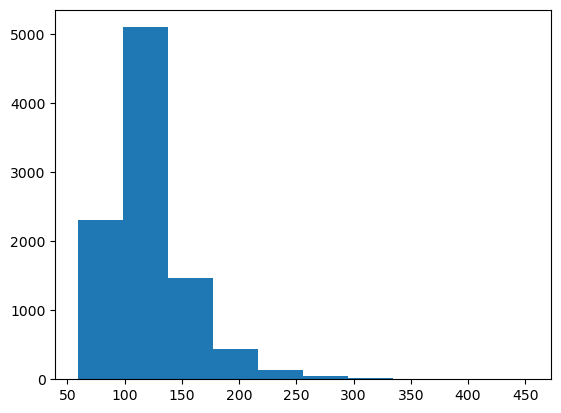

In [6]:
img_sizes = []
for gg in all_gals:
    mm, _, _ = gg['data']
    img_sizes.append(mm.shape[0])

plt.hist(img_sizes)
plt.show()

EFIGI 은하에 대해서 테스트 하는건 어떰? 

RandomCrop을 할 의미가 있을까?
은하의 중심이 어느정도 결정되어있고, 일부를 봐야하는 상황은 없으며, radial한 pattern이 중요한데. 
거기다가 은하별로 크기가 많이 차이나서 잘못하면 텅텅 빈 공간을 잘라오는 수가 있음. 

In [7]:
img_size =128
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8), 
    #transforms.RandomGrayscale(p=0.2), 
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.2])])#[0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])]) 

test_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.2])])#0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

## Split one chunk of dataset into train and test
#### Use torch.utils.data.random_split or [torch.utils.data.SubsetRandomSampler](https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887)

random_split takes a dataset -- for example, a tuple (tensor of data, tensor of label).  
SubsetRandomSampler is sent to a DataLoader as an optional argument. SubsetRandomSampler better suits to my case.

In [8]:
from torch.utils.data import SubsetRandomSampler

args.batch_size = 512
# data prepare
frac_train = 0.8

all_data = TonemapImageDatasetPair(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                     labels=cat['TT'].to_numpy(),
                                     train=True, 
                                     transform=train_transform)

all_data_val = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                     labels=cat['TT'].to_numpy(),
                                     train=False, 
                                     transform=test_transform)
len_data = len(all_data)

data_idx = np.arange(len_data)
np.random.shuffle(data_idx)
ind = int(np.floor(len_data * frac_train))
train_idx, test_idx = data_idx[:ind], data_idx[ind:]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(all_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True, drop_last=True,
                         sampler=train_sampler)

test_loader = DataLoader(all_data_val, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True, drop_last=True,
                         sampler=test_sampler)


## Q 
shuflle = False is forced because "sampler option is mutually exclusive with shuffle".  
Do I get different batches in different epochs? I want to train on different set of contrastive examples...   

## quick check images

In [9]:
from tqdm import tqdm
from torch.cuda.amp import autocast
feature_arr = []
for images, _ in tqdm(train_loader):
    images = torch.cat(images, dim=0)
    #images = images.to(args.device)


  0%|          | 0/14 [00:00<?, ?it/s]/home/hoseung/Work/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/astroBF/astrobf/tmo.py:268: Runti

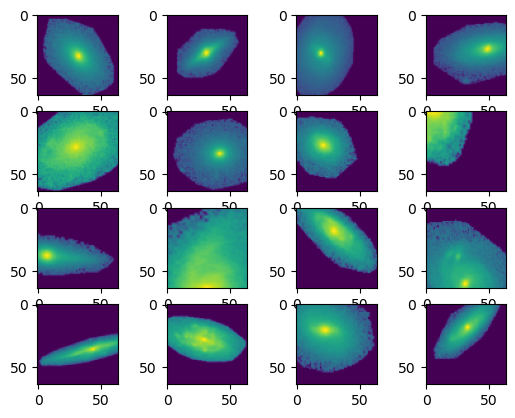

In [10]:
fig, axs = plt.subplots(4,4)
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.imshow(images[i][0])

#plt.tight_layout()
plt.show()

In [11]:
print("mean", images[1].mean(), "max", images[1].max(), "min", images[1].min())

mean tensor(-1.8882) max tensor(2.3824) min tensor(-2.5000)


#### Input 이미지는 문제 없어보임. 근데 왜 첫 loss 부터 nan이 나오는가? 

In [9]:
import importlib
importlib.reload(simclr)
importlib.reload(simclr.models)

<module 'atm.simclr.models' from '/home/hoseung/Work/ATM/atm/simclr/models.py'>

In [10]:
model = simclr.models.ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                           last_epoch=-1)

특정 배치에 있었던 이미지를 보려면?

loss는 쬐끔 줄어드려던 중이었음. weight가 explode한 듯? 

In [11]:
np.seterr(divide='ignore')

with torch.cuda.device(args.gpu_index):
    simc = simclr.models.SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simc.train(train_loader) # model is saved at the end of train.

  0%|          | 0/14 [00:00<?, ?it/s]/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/14 [00:02<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 11.77 GiB total capacity; 9.45 GiB already allocated; 210.00 MiB free; 9.67 GiB reserved in total by PyTorch)

In [17]:
np.seterr(divide='ignore')

with torch.cuda.device(args.gpu_index):
    simc = simclr.models.SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simc.train(train_loader) # model is saved at the end of train.

  0%|          | 0/14 [00:00<?, ?it/s]

feature min max -0.614746 0.624023
current loss tensor(6.9046, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 1/14 [00:01<00:16,  1.27s/it]

feature min max -0.616699 0.629883
current loss tensor(6.8819, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 2/14 [00:01<00:08,  1.38it/s]

feature min max -0.631348 0.643555
current loss tensor(6.9004, device='cuda:0', grad_fn=<NllLossBackward>)


 21%|██▏       | 3/14 [00:01<00:06,  1.82it/s]

feature min max -0.615723 0.62793
current loss tensor(6.9031, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▊       | 4/14 [00:02<00:04,  2.14it/s]

feature min max -0.619629 0.630371
current loss tensor(6.8663, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 5/14 [00:02<00:03,  2.37it/s]

feature min max -0.621582 0.633301
current loss tensor(6.8742, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 6/14 [00:02<00:03,  2.52it/s]

feature min max -59.2188 52.4375
current loss tensor(6.9910, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 7/14 [00:03<00:02,  2.62it/s]

feature min max -526.0 498.0
current loss tensor(6.8321, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 8/14 [00:03<00:02,  2.69it/s]

feature min max -1271.0 1211.0
current loss tensor(6.7893, device='cuda:0', grad_fn=<NllLossBackward>)


 64%|██████▍   | 9/14 [00:04<00:01,  2.74it/s]

feature min max -2080.0 1982.0
current loss tensor(6.7055, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 10/14 [00:04<00:01,  2.78it/s]

feature min max -2794.0 2654.0
current loss tensor(6.7217, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▊  | 11/14 [00:04<00:01,  2.80it/s]

feature min max -3388.0 3212.0
current loss tensor(6.6837, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 12/14 [00:05<00:00,  2.82it/s]

feature min max -4020.0 3810.0
current loss tensor(6.5888, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 13/14 [00:05<00:00,  2.83it/s]

feature min max -4368.0 4152.0
current loss tensor(6.5025, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/14 [00:00<?, ?it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 1/14 [00:01<00:16,  1.28s/it]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 2/14 [00:01<00:08,  1.37it/s]

feature min max -4660.0 4428.0
current loss tensor(6.5194, device='cuda:0', grad_fn=<NllLossBackward>)


 21%|██▏       | 3/14 [00:01<00:06,  1.80it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▊       | 4/14 [00:02<00:04,  2.13it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 5/14 [00:02<00:03,  2.36it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 6/14 [00:02<00:03,  2.54it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 7/14 [00:03<00:02,  2.66it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 8/14 [00:03<00:02,  2.73it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 64%|██████▍   | 9/14 [00:04<00:01,  2.71it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 10/14 [00:04<00:01,  2.70it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▊  | 11/14 [00:04<00:01,  2.77it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 12/14 [00:05<00:00,  2.82it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 13/14 [00:05<00:00,  2.85it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 13/14 [00:05<00:00,  2.24it/s]


KeyboardInterrupt: 

# representation quality check

## linear evaluation protocol, a standard way
Train a linear classifier on the fixed representations

## Load checkpoint

In [33]:
if True:
    checkpoint = torch.load('./runs/Aug23_00-13-48_hoseung/checkpoint_0300.pth.tar', map_location=args.device)
    state_dict = checkpoint['state_dict']
    
    resnet = simclr.models.ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)
    resnet.to(args.device)
    log = resnet.load_state_dict(state_dict, strict=False)

    print(log)
else:
    resnet = simc.model
    print("Using live simc instance")



<All keys matched successfully>


### Discard the projection head and leave the original backbone. 

In [21]:
# drop the projection head
resnet.backbone.fc = nn.Identity()

## t_SNE 

### Get features of the test set

test_transform에서 to_tensor해줬는데...??

### Test set Evaluation

In [34]:
from tqdm import tqdm
from torch.cuda.amp import autocast
feature_arr = []
for images, _ in tqdm(test_loader):
    #images = torch.cat(images, dim=0)
    images = images.to(args.device)

    # autocast <- AMP
    with autocast(enabled=args.fp16_precision):
        features = resnet.backbone(images)
        
    feature_arr.append(features.cpu().detach().numpy())

feature_arr = np.concatenate(feature_arr)

100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


In [43]:
resnet.backbone.parameters()

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [68]:
b1 = resnet.backbone.layer4[0]

In [70]:
b1

Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [72]:
b1.conv1.weight

Parameter containing:
tensor([[[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        ...,


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]]], device='cuda:0', requires_grad=True)

In [21]:
from sklearn.manifold import TSNE

In [54]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature_arr)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# 2D projection of 1024(?)-dim features
tsne = TSNE(n_components=2).fit_transform(features)


In [11]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(args.device)

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [12]:
from torch.utils.data import DataLoader
def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
    train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=download,
                                  transform=transforms.ToTensor())

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)

    test_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=download,
                                  transform=transforms.ToTensor())

    test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
    return train_loader, test_loader

train_loader, test_loader = get_cifar10_data_loaders(download=True)
# num_workers=0. Using multiple (even num_workers=1) causes an error 'can only test a child process'.

Files already downloaded and verified
Files already downloaded and verified


In [120]:
epochs = 100
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch,y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        
        logits = resnet(x_batch)
        loss = criterion(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
        top1_train_accuracy += top1[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    top1_train_accuracy /= (counter + 1)
    top1_accuracy = 0
    top5_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)

        logits = resnet(x_batch)

        top1, top5 = accuracy(logits, y_batch, topk=(1,5))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]

    top1_accuracy /= (counter + 1)
    top5_accuracy /= (counter + 1)
    print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

KeyboardInterrupt: 

In [ ]:
class SimCLRClassifier(nn.Module):
    def __init__(self, base_model, freeze_base, base_feature_size=512, n_views=2):
        self.embeddings = base_model
        
        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False
                
        self.classifier = nn.Linear(in_features = base_feature_size, 
                                   out_features = n_views) #
    
    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)
    
class SimCLRClassifierModule

In [63]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(data_loader, module):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module.eval().cuda()
        true_y, pred_y = [], []
        for i, batch_ in enumerate(data_loader):
            X, y = batch_
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(X.cuda()), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
        print(classification_report(true_y, pred_y, digits=3))
        return true_y, pred_y

_ = evaluate(module.val_dataloader(), module)